In [2]:
import torch
import torch.optim as optim

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchinfo import summary

from src.datasets import IrmaDataset
from src.transforms import MinMaxScaler, Sobel, Laplacian, GammaCorrection, HistogramEqualizer
from src.models import VAE, PVAE
from src.utils.model_utils import train_val_split, get_latent, predict
from src.utils.visualization import (
    plot_reconstructions,
    plot_2d,
    sample_images,
    plot_history,
)
from src.utils.training_funcs import (
    train,
    validate,
    pred_kl_reconstruction_loss,
    kl_reconstruction_loss,
    get_metrics_str,
    pred_loss,
)

In [3]:
torch.backends.cudnn.benchmark = True
batch_size = 32

In [81]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            HistogramEqualizer(),
            Laplacian(mode='add'),
            HistogramEqualizer()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=24)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=24)}
# train_datasets = train_val_split(datasets['train'], 1 / 4, random_state=12)
# datasets['train_pred'] = train_datasets['val']
# datasets['train'] = train_datasets['train']

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']),  len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

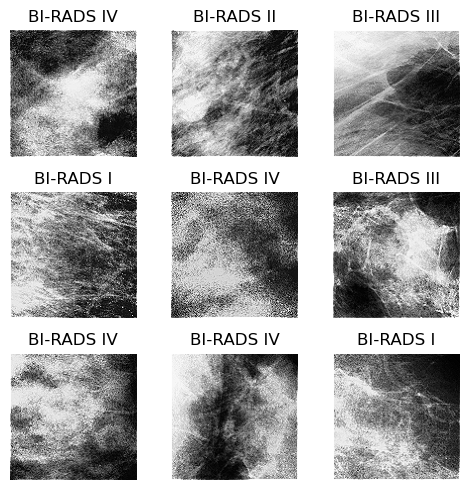

In [ ]:
sample_images(dataloaders['train'], label_mapper=IrmaDataset.get_class_label, plot_borders=False)

## PVAE - 64

In [80]:
pvae_64 = PVAE(
    latent_dim=64,
    n_channels=1,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
    pred_layers=[128, 64],
    n_classes=4,
    use_batchnorm=True,
    clamp_output=False
)
summary(pvae_64, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pvae_64.parameters())
pvae_64.to(device)

hist = train(pvae_64, optimizer, dataloaders['train'], dataloaders['val'], 32, pred_kl_reconstruction_loss)

[epoch: 1] train_loss: 23.9888 - train_rec_loss: 22.5897 - train_kl_loss: 0.0318 - train_pred_loss: 1.3673 - train_accuracy: 0.3024 - val_loss: 9.1408 - val_rec_loss: 7.7995 - val_kl_loss: 0.0610 - val_pred_loss: 1.2803 - val_accuracy: 0.4573
[epoch: 2] train_loss: 8.4998 - train_rec_loss: 7.2234 - train_kl_loss: 0.0624 - train_pred_loss: 1.2139 - train_accuracy: 0.5090 - val_loss: 8.1330 - val_rec_loss: 6.8991 - val_kl_loss: 0.0601 - val_pred_loss: 1.1737 - val_accuracy: 0.5706
[epoch: 3] train_loss: 7.9935 - train_rec_loss: 6.7667 - train_kl_loss: 0.0623 - train_pred_loss: 1.1645 - train_accuracy: 0.5602 - val_loss: 7.8062 - val_rec_loss: 6.5652 - val_kl_loss: 0.0687 - val_pred_loss: 1.1723 - val_accuracy: 0.5507
[epoch: 4] train_loss: 7.5761 - train_rec_loss: 6.3601 - train_kl_loss: 0.0663 - train_pred_loss: 1.1498 - train_accuracy: 0.5831 - val_loss: 7.3968 - val_rec_loss: 6.2026 - val_kl_loss: 0.0649 - val_pred_loss: 1.1293 - val_accuracy: 0.5984
[epoch: 5] train_loss: 7.3044 - tr

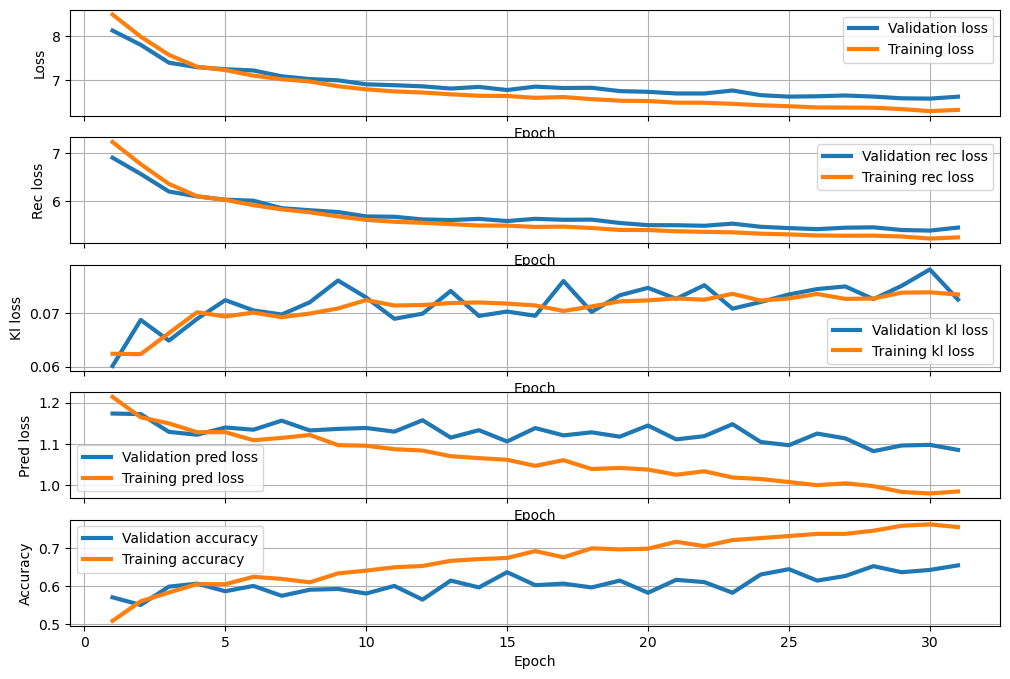

In [83]:
plot_history(hist[1:])

test_loss: 6.7108 - test_rec_loss: 5.5252 - test_kl_loss: 0.0725 - test_pred_loss: 1.1131 - test_accuracy: 0.6203


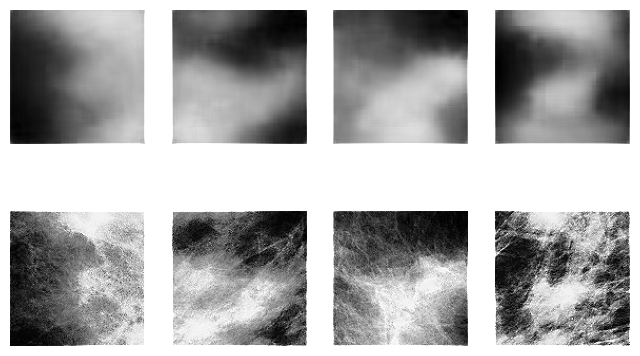

In [84]:
test_metrics = validate(pvae_64, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(pvae_64, dataloaders['test'], plot_borders=False)

In [85]:
train_latent, train_labels = get_latent(pvae_64, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae_64, dataloaders["train_pred"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

KeyError: 'train_pred'

In [ ]:
train_latent, train_labels = get_latent(pvae_64, dataloaders["train"])
# train_pred_latent, train_pred_labels = get_latent(pvae_64, dataloaders["train_pred"])
val_latent, val_labels = get_latent(pvae_64, dataloaders["val"])
latent, labels = get_latent(pvae_64, dataloaders["test"])

In [ ]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
# train_pred_latent, train_pred_labels = train_pred_latent.astype('float32'), train_pred_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [ ]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

# train_pred_ds = TensorDataset(torch.tensor(train_pred_latent), torch.tensor(train_pred_labels))
# train_pred_dl = DataLoader(train_pred_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [ ]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(64, 1024),
    torch.nn.GELU(),
    torch.nn.Linear(1024, 512),
    torch.nn.GELU(),
    torch.nn.Linear(512, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 1024]                66,560
├─GELU: 1-2                              [32, 1024]                --
├─Linear: 1-3                            [32, 512]                 524,800
├─GELU: 1-4                              [32, 512]                 --
├─Linear: 1-5                            [32, 256]                 131,328
├─GELU: 1-6                              [32, 256]                 --
├─Linear: 1-7                            [32, 128]                 32,896
├─GELU: 1-8                              [32, 128]                 --
├─Linear: 1-9                            [32, 64]                  8,256
├─GELU: 1-10                             [32, 64]                  --
├─Linear: 1-11                           [32, 4]                   260
├─Softmax: 1-12                          [32, 4]               

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 128, pred_loss)
# hist = [*hist, *train(pred_model, optimizer, train_pred_dl, val_dl, 128, pred_loss)]

[epoch: 1] train_loss: 1.3847 - train_predict_loss: 1.3847 - train_accuracy: 0.2496 - val_loss: 1.3827 - val_predict_loss: 1.3827 - val_accuracy: 0.2724
[epoch: 2] train_loss: 1.3570 - train_predict_loss: 1.3570 - train_accuracy: 0.4756 - val_loss: 1.3073 - val_predict_loss: 1.3073 - val_accuracy: 0.5169
[epoch: 3] train_loss: 1.1952 - train_predict_loss: 1.1952 - train_accuracy: 0.5971 - val_loss: 1.1969 - val_predict_loss: 1.1969 - val_accuracy: 0.5089
[epoch: 4] train_loss: 1.1146 - train_predict_loss: 1.1146 - train_accuracy: 0.6160 - val_loss: 1.1828 - val_predict_loss: 1.1828 - val_accuracy: 0.5169
[epoch: 5] train_loss: 1.0915 - train_predict_loss: 1.0915 - train_accuracy: 0.6230 - val_loss: 1.1769 - val_predict_loss: 1.1769 - val_accuracy: 0.5288
[epoch: 6] train_loss: 1.0696 - train_predict_loss: 1.0696 - train_accuracy: 0.6791 - val_loss: 1.1631 - val_predict_loss: 1.1631 - val_accuracy: 0.5726
[epoch: 7] train_loss: 1.0280 - train_predict_loss: 1.0280 - train_accuracy: 0.745

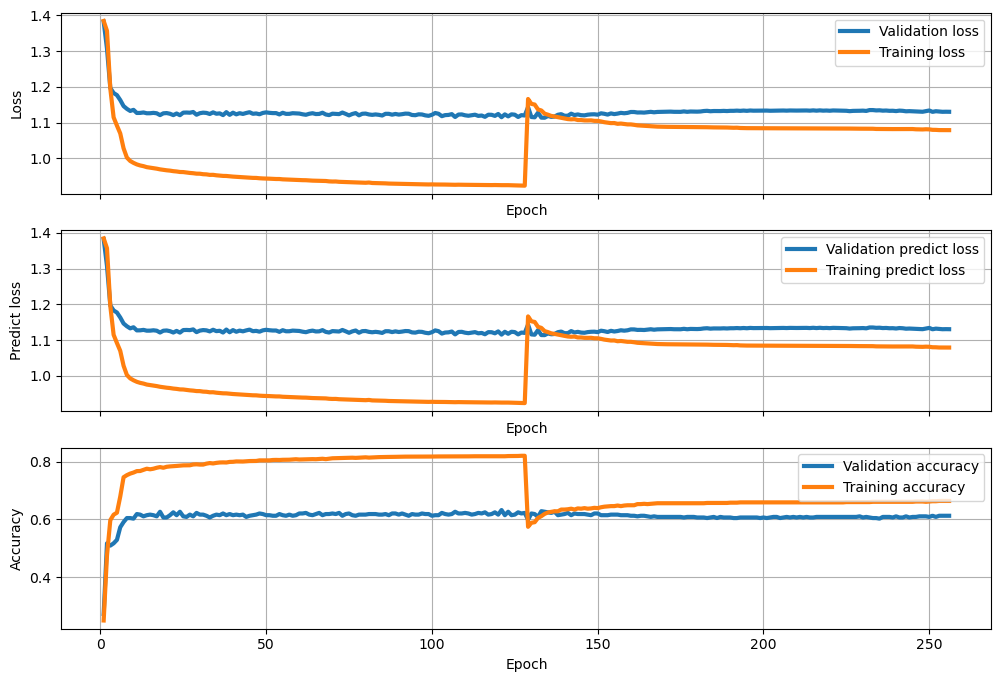

In [ ]:
plot_history(hist)

In [ ]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.1463 - test_predict_loss: 1.1463 - test_accuracy: 0.5944


In [ ]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       129
           1       0.56      0.60      0.58       128
           2       0.43      0.40      0.41       115
           3       0.54      0.54      0.54       131

    accuracy                           0.61       503
   macro avg       0.60      0.60      0.60       503
weighted avg       0.61      0.61      0.61       503



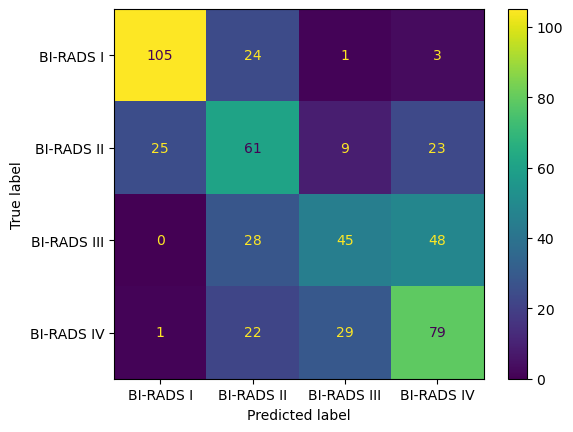

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

## PVAE - 128

In [8]:
pvae = PVAE(
    latent_dim=128,
    n_channels=2,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 84)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(84, 6, 6),
    linear_layers=[128, 64],
    pred_layers=[256, 128, 64],
    n_classes=4,
    clamp_output=False
)
summary(pvae, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 84, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─GELU: 3-2                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         221,312
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 96, 28, 28]          110,688
│    │    └─GELU: 3-8                    [32, 96, 28, 28]          --
│    │    └─MaxPool2d: 3-9               [32, 96, 14, 14]          --
│    │    └─Conv2d: 3-10                 [32, 84, 12, 12]          72,66

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pvae.parameters())
pvae.to(device)

hist = train(pvae, optimizer, dataloaders['train'], dataloaders['val'], 32, pred_kl_reconstruction_loss)

[epoch: 1] train_loss: 7.8929 - train_rec_loss: 6.9060 - train_kl_loss: 0.0546 - train_pred_loss: 0.9324 - train_accuracy: 0.8068 - val_loss: 8.1059 - val_rec_loss: 6.8471 - val_kl_loss: 0.0548 - val_pred_loss: 1.2040 - val_accuracy: 0.5368
[epoch: 2] train_loss: 7.5395 - train_rec_loss: 6.5849 - train_kl_loss: 0.0605 - train_pred_loss: 0.8942 - train_accuracy: 0.8500 - val_loss: 8.0475 - val_rec_loss: 6.8085 - val_kl_loss: 0.0602 - val_pred_loss: 1.1788 - val_accuracy: 0.5547
[epoch: 3] train_loss: 7.5293 - train_rec_loss: 6.5826 - train_kl_loss: 0.0602 - train_pred_loss: 0.8865 - train_accuracy: 0.8553 - val_loss: 8.0304 - val_rec_loss: 6.8002 - val_kl_loss: 0.0614 - val_pred_loss: 1.1688 - val_accuracy: 0.5686
[epoch: 4] train_loss: 7.5464 - train_rec_loss: 6.5819 - train_kl_loss: 0.0613 - train_pred_loss: 0.9032 - train_accuracy: 0.8387 - val_loss: 8.0917 - val_rec_loss: 6.8461 - val_kl_loss: 0.0609 - val_pred_loss: 1.1846 - val_accuracy: 0.5547
[epoch: 5] train_loss: 7.5643 - trai

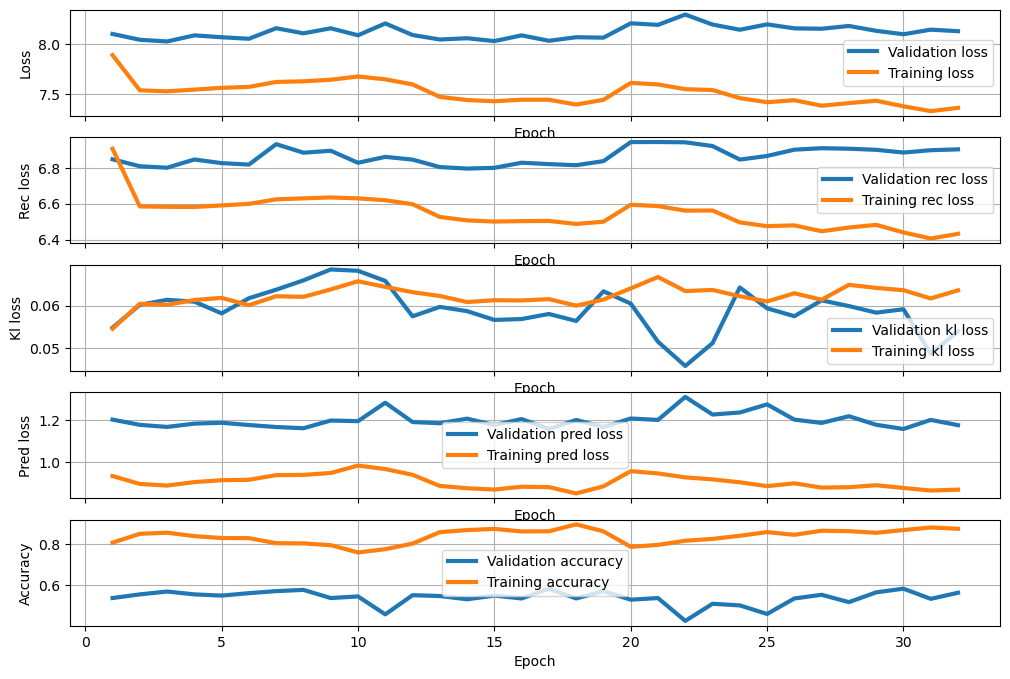

In [29]:
plot_history(hist)

test_loss: 8.1240 - test_rec_loss: 6.9254 - test_kl_loss: 0.0547 - test_pred_loss: 1.1439 - test_accuracy: 0.5984


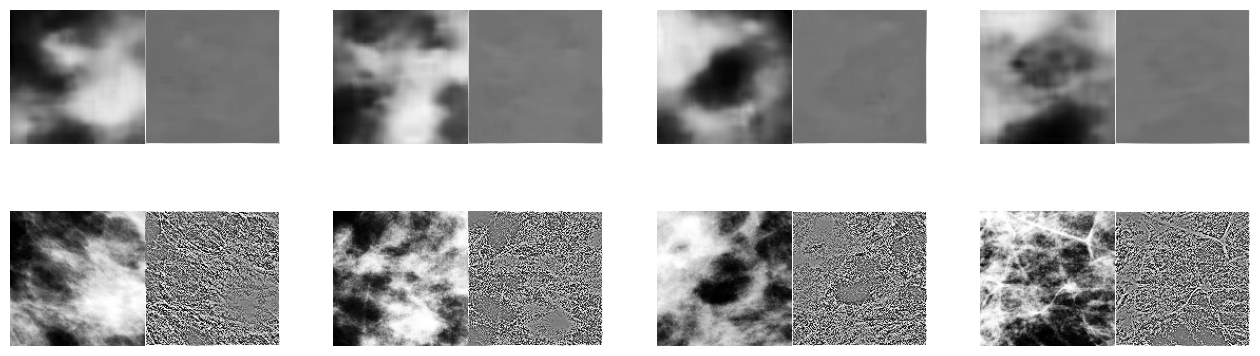

In [30]:
test_metrics = validate(pvae, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(pvae, dataloaders['test'], plot_borders=True)

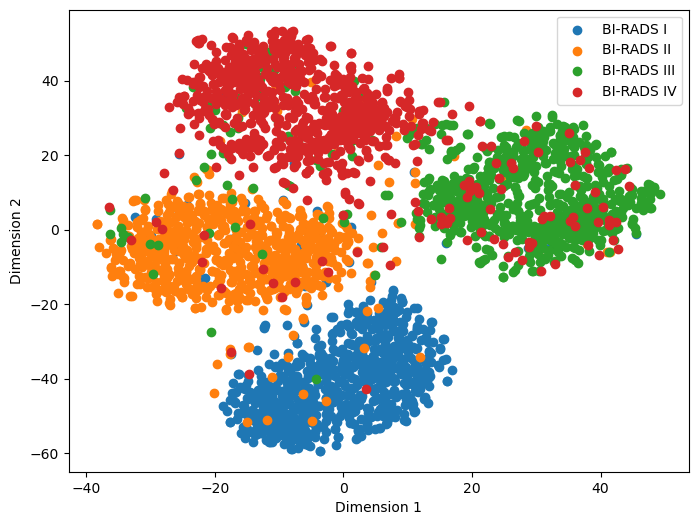

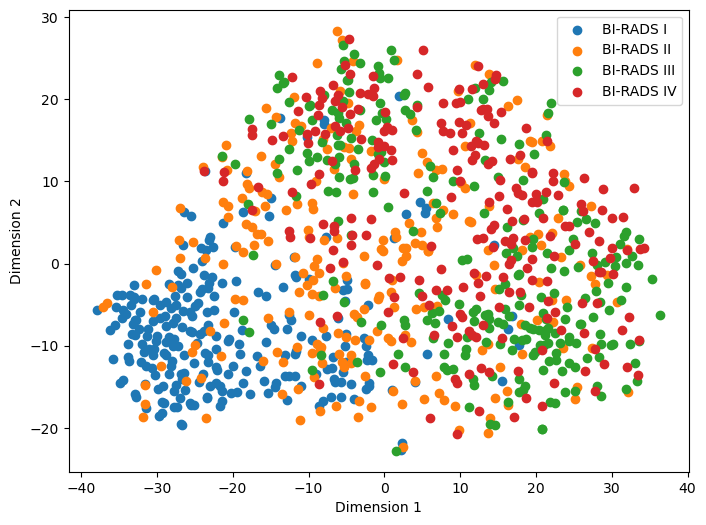

In [31]:
train_latent, train_labels = get_latent(pvae, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae, dataloaders["train_pred"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [32]:
train_latent, train_labels = get_latent(pvae, dataloaders["train"])
val_latent, val_labels = get_latent(pvae, dataloaders["val"])
latent, labels = get_latent(pvae, dataloaders["test"])

In [33]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [34]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [52]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(128, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 16,512
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 90,948
Trainable params: 90,948
Non-trainable params: 0
Total mult-adds (M): 2.91
Input size (MB): 0.02
Forward/backward pass

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.000002)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 64, pred_loss)

[epoch: 1] train_loss: 0.8360 - train_predict_loss: 0.8360 - train_accuracy: 0.9111 - val_loss: 1.1614 - val_predict_loss: 1.1614 - val_accuracy: 0.5686
[epoch: 2] train_loss: 0.8359 - train_predict_loss: 0.8359 - train_accuracy: 0.9107 - val_loss: 1.1614 - val_predict_loss: 1.1614 - val_accuracy: 0.5686
[epoch: 3] train_loss: 0.8357 - train_predict_loss: 0.8357 - train_accuracy: 0.9107 - val_loss: 1.1614 - val_predict_loss: 1.1614 - val_accuracy: 0.5686
[epoch: 4] train_loss: 0.8356 - train_predict_loss: 0.8356 - train_accuracy: 0.9111 - val_loss: 1.1614 - val_predict_loss: 1.1614 - val_accuracy: 0.5686
[epoch: 5] train_loss: 0.8354 - train_predict_loss: 0.8354 - train_accuracy: 0.9111 - val_loss: 1.1614 - val_predict_loss: 1.1614 - val_accuracy: 0.5686
[epoch: 6] train_loss: 0.8353 - train_predict_loss: 0.8353 - train_accuracy: 0.9111 - val_loss: 1.1613 - val_predict_loss: 1.1613 - val_accuracy: 0.5686
[epoch: 7] train_loss: 0.8352 - train_predict_loss: 0.8352 - train_accuracy: 0.911

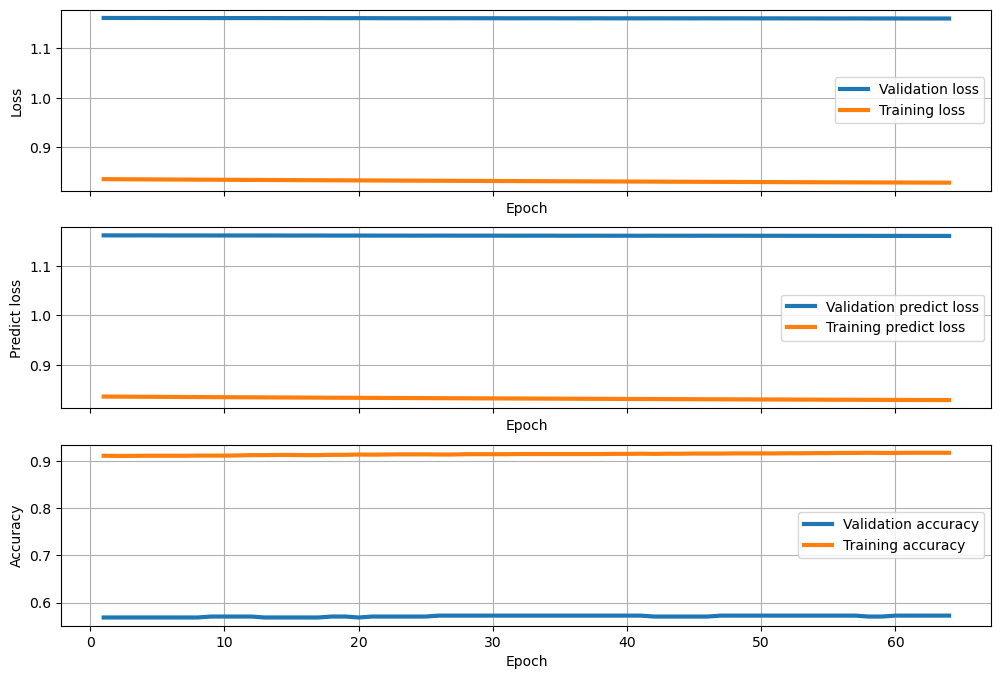

In [63]:
plot_history(hist)

In [64]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.1221 - test_predict_loss: 1.1221 - test_accuracy: 0.6103


In [47]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       133
           1       0.51      0.58      0.55       118
           2       0.55      0.50      0.53       121
           3       0.54      0.50      0.52       131

    accuracy                           0.61       503
   macro avg       0.60      0.60      0.60       503
weighted avg       0.61      0.61      0.61       503



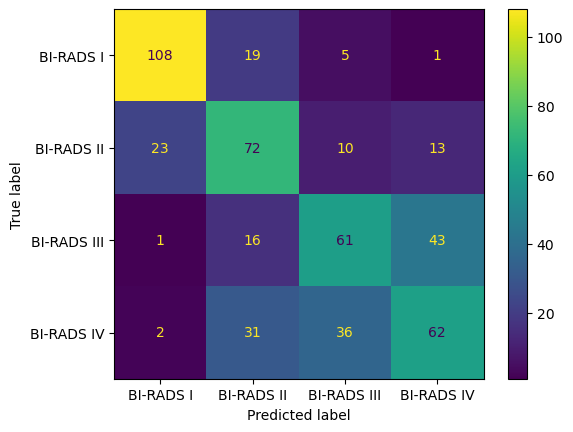

In [40]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

## PVAE - 128

In [5]:
pvae = PVAE(
    latent_dim=128,
    n_channels=1,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 84)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(84, 6, 6),
    linear_layers=[128, 64],
    pred_layers=[256, 128, 64],
    use_batchnorm=True,
    n_classes=4,
    clamp_output=False
)
summary(pvae, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 84, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pvae.parameters())
pvae.to(device)

hist = train(pvae, optimizer, dataloaders['train'], dataloaders['val'], 32, pred_kl_reconstruction_loss)

[epoch: 1] train_loss: 33.6639 - train_rec_loss: 32.3375 - train_kl_loss: 0.0363 - train_pred_loss: 1.2901 - train_accuracy: 0.3937 - val_loss: 9.5785 - val_rec_loss: 8.2896 - val_kl_loss: 0.0558 - val_pred_loss: 1.2331 - val_accuracy: 0.4751
[epoch: 2] train_loss: 8.7407 - train_rec_loss: 7.4712 - train_kl_loss: 0.0587 - train_pred_loss: 1.2109 - train_accuracy: 0.5080 - val_loss: 8.5445 - val_rec_loss: 7.2734 - val_kl_loss: 0.0674 - val_pred_loss: 1.2037 - val_accuracy: 0.5229
[epoch: 3] train_loss: 8.0747 - train_rec_loss: 6.8511 - train_kl_loss: 0.0642 - train_pred_loss: 1.1594 - train_accuracy: 0.5702 - val_loss: 8.0702 - val_rec_loss: 6.8185 - val_kl_loss: 0.0638 - val_pred_loss: 1.1878 - val_accuracy: 0.5288
[epoch: 4] train_loss: 7.6639 - train_rec_loss: 6.4385 - train_kl_loss: 0.0646 - train_pred_loss: 1.1608 - train_accuracy: 0.5739 - val_loss: 7.6942 - val_rec_loss: 6.4312 - val_kl_loss: 0.0666 - val_pred_loss: 1.1963 - val_accuracy: 0.5328
[epoch: 5] train_loss: 7.3509 - tr

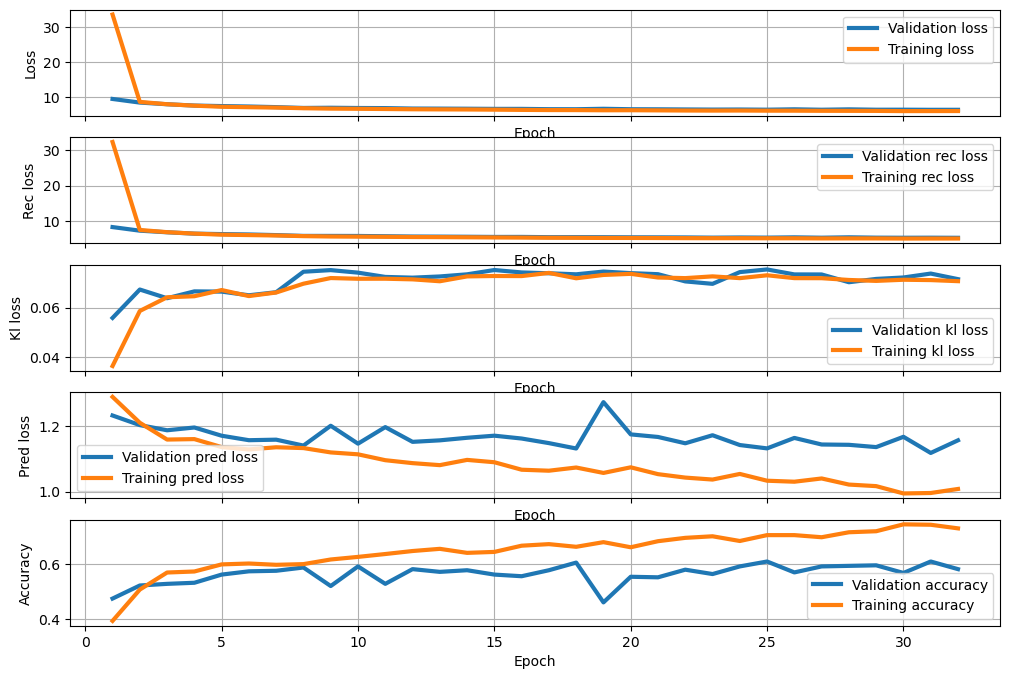

In [7]:
plot_history(hist)

test_loss: 6.5626 - test_rec_loss: 5.3755 - test_kl_loss: 0.0722 - test_pred_loss: 1.1149 - test_accuracy: 0.6302


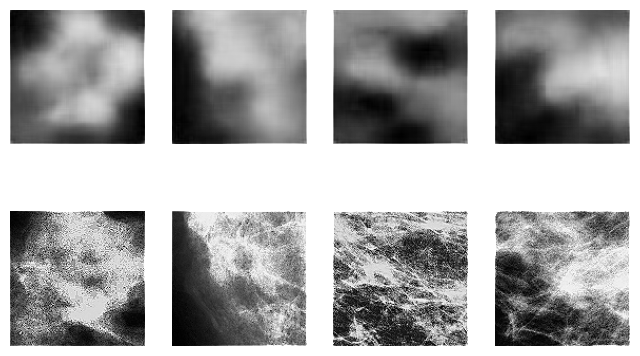

In [8]:
test_metrics = validate(pvae, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(pvae, dataloaders['test'], plot_borders=False)

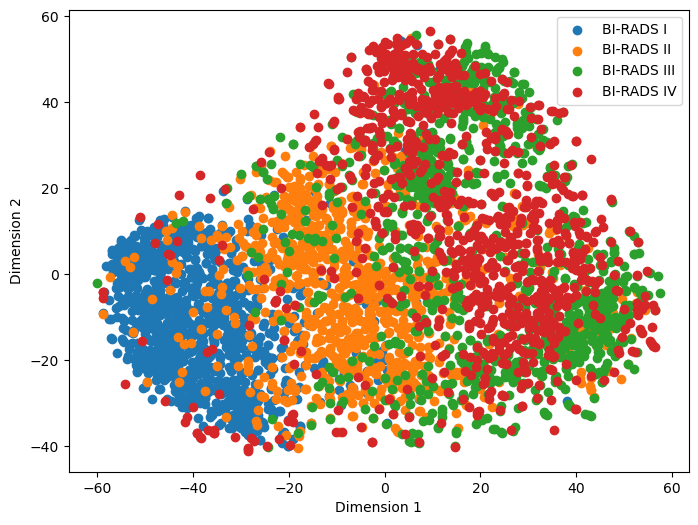

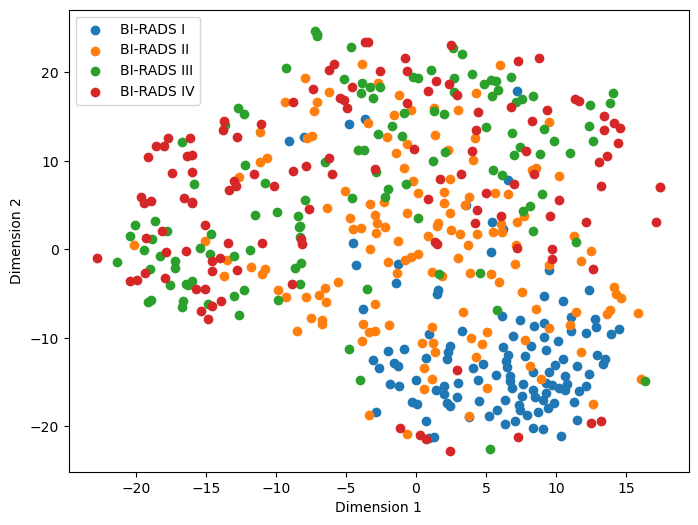

In [10]:
train_latent, train_labels = get_latent(pvae, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae, dataloaders["val"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [11]:
train_latent, train_labels = get_latent(pvae, dataloaders["train"])
val_latent, val_labels = get_latent(pvae, dataloaders["val"])
latent, labels = get_latent(pvae, dataloaders["test"])

In [12]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [13]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [30]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(128, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 16,512
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 90,948
Trainable params: 90,948
Non-trainable params: 0
Total mult-adds (M): 2.91
Input size (MB): 0.02
Forward/backward pass

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.000005)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 256, pred_loss)

[epoch: 1] train_loss: 1.0002 - train_predict_loss: 1.0002 - train_accuracy: 0.7476 - val_loss: 1.1087 - val_predict_loss: 1.1087 - val_accuracy: 0.6243
[epoch: 2] train_loss: 0.9993 - train_predict_loss: 0.9993 - train_accuracy: 0.7486 - val_loss: 1.1082 - val_predict_loss: 1.1082 - val_accuracy: 0.6223
[epoch: 3] train_loss: 0.9984 - train_predict_loss: 0.9984 - train_accuracy: 0.7509 - val_loss: 1.1083 - val_predict_loss: 1.1083 - val_accuracy: 0.6243
[epoch: 4] train_loss: 0.9976 - train_predict_loss: 0.9976 - train_accuracy: 0.7511 - val_loss: 1.1078 - val_predict_loss: 1.1078 - val_accuracy: 0.6223
[epoch: 5] train_loss: 0.9969 - train_predict_loss: 0.9969 - train_accuracy: 0.7514 - val_loss: 1.1077 - val_predict_loss: 1.1077 - val_accuracy: 0.6243
[epoch: 6] train_loss: 0.9961 - train_predict_loss: 0.9961 - train_accuracy: 0.7511 - val_loss: 1.1075 - val_predict_loss: 1.1075 - val_accuracy: 0.6262
[epoch: 7] train_loss: 0.9954 - train_predict_loss: 0.9954 - train_accuracy: 0.752

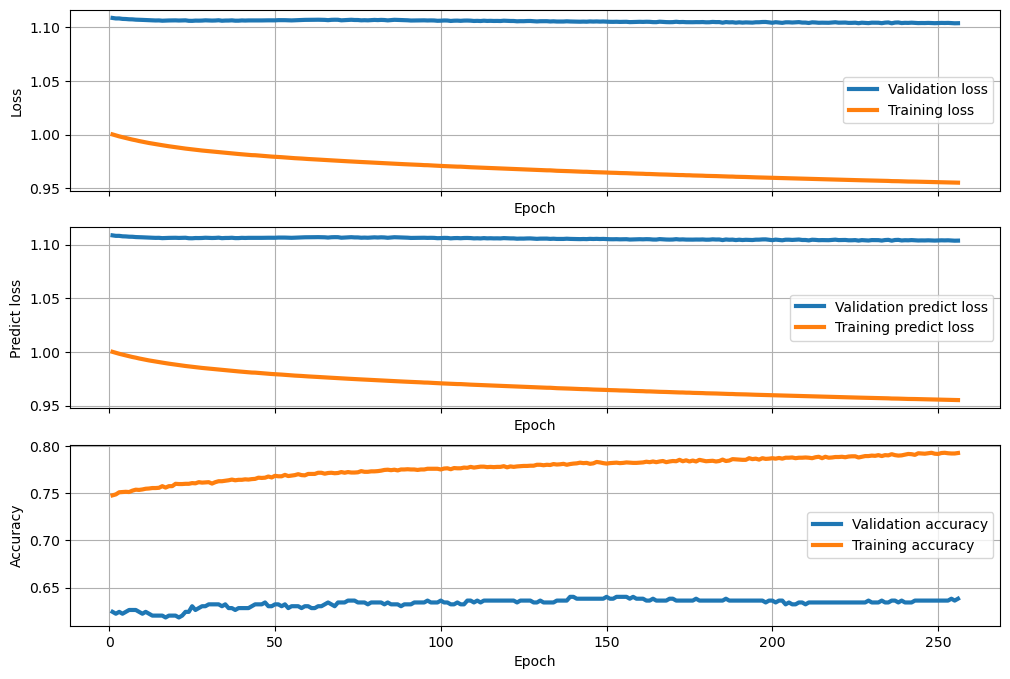

In [37]:
plot_history(hist)

In [38]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.0778 - test_predict_loss: 1.0778 - test_accuracy: 0.6600


In [39]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       133
           1       0.60      0.58      0.59       118
           2       0.59      0.54      0.56       121
           3       0.60      0.66      0.63       131

    accuracy                           0.66       503
   macro avg       0.66      0.65      0.65       503
weighted avg       0.66      0.66      0.66       503



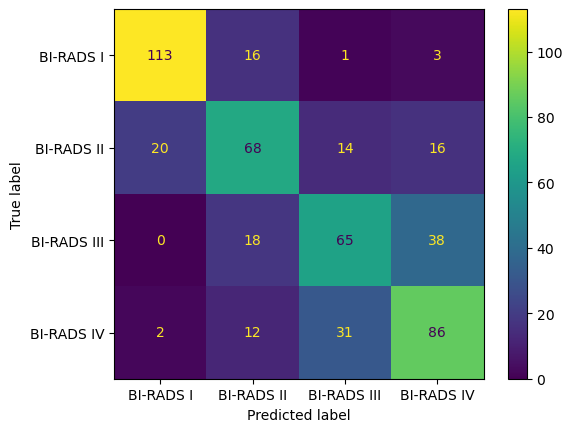

In [40]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

## MinMax

In [47]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            Laplacian(mode='add'),
            MinMaxScaler()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=12)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=12)}
# train_datasets = train_val_split(datasets['train'], 1 / 4, random_state=12)
# datasets['train'] = train_datasets['train']

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']),  len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

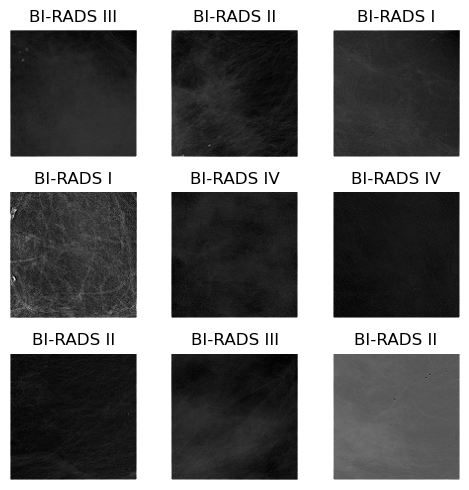

In [48]:
sample_images(dataloaders['train'], label_mapper=IrmaDataset.get_class_label, plot_borders=False)

### PVAE - 128

In [52]:
pvae = PVAE(
    latent_dim=128,
    n_channels=1,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 84)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(84, 6, 6),
    linear_layers=[128, 64],
    pred_layers=[256, 128, 64],
    use_batchnorm=True,
    n_classes=4,
    clamp_output=False
)
summary(pvae, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 84, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pvae.parameters())
pvae.to(device)

hist = train(pvae, optimizer, dataloaders['train'], dataloaders['val'], 24, pred_kl_reconstruction_loss)

[epoch: 1] train_loss: 18.4068 - train_rec_loss: 16.8967 - train_kl_loss: 0.1430 - train_pred_loss: 1.3672 - train_accuracy: 0.2880 - val_loss: 2.2815 - val_rec_loss: 0.9478 - val_kl_loss: 0.0183 - val_pred_loss: 1.3154 - val_accuracy: 0.3897
[epoch: 2] train_loss: 1.9709 - train_rec_loss: 0.6624 - train_kl_loss: 0.0154 - train_pred_loss: 1.2931 - train_accuracy: 0.4024 - val_loss: 1.7070 - val_rec_loss: 0.4281 - val_kl_loss: 0.0134 - val_pred_loss: 1.2656 - val_accuracy: 0.4274
[epoch: 3] train_loss: 1.6401 - train_rec_loss: 0.3736 - train_kl_loss: 0.0105 - train_pred_loss: 1.2560 - train_accuracy: 0.4462 - val_loss: 1.5720 - val_rec_loss: 0.2916 - val_kl_loss: 0.0120 - val_pred_loss: 1.2685 - val_accuracy: 0.4274
[epoch: 4] train_loss: 1.5322 - train_rec_loss: 0.2811 - train_kl_loss: 0.0103 - train_pred_loss: 1.2407 - train_accuracy: 0.4701 - val_loss: 1.5263 - val_rec_loss: 0.2703 - val_kl_loss: 0.0104 - val_pred_loss: 1.2456 - val_accuracy: 0.4553
[epoch: 5] train_loss: 1.4966 - tr

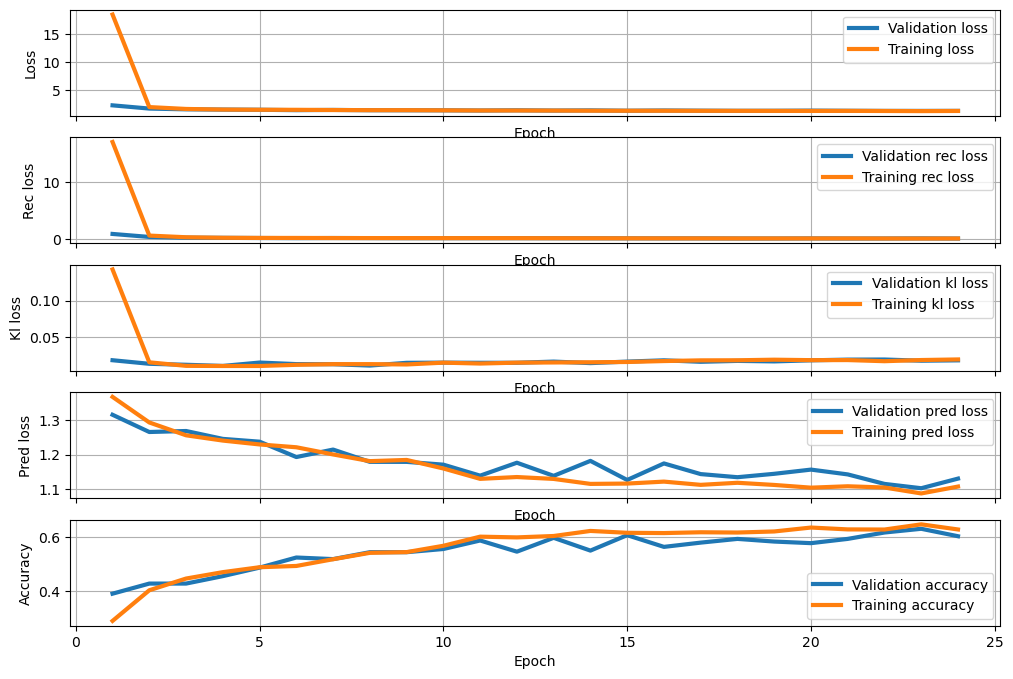

In [54]:
plot_history(hist)

test_loss: 1.3378 - test_rec_loss: 0.1769 - test_kl_loss: 0.0176 - test_pred_loss: 1.1433 - test_accuracy: 0.5924


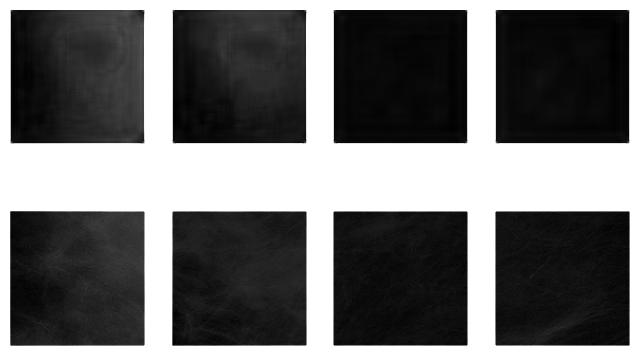

In [55]:
test_metrics = validate(pvae, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(pvae, dataloaders['test'], plot_borders=False)

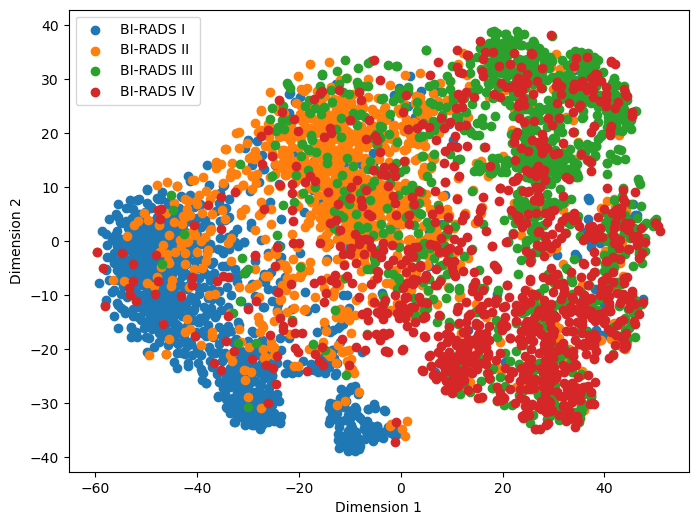

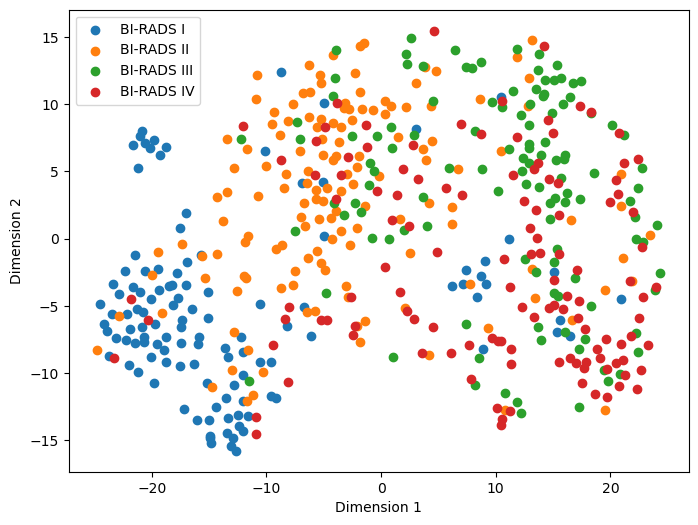

In [57]:
train_latent, train_labels = get_latent(pvae, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae, dataloaders["val"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [58]:
train_latent, train_labels = get_latent(pvae, dataloaders["train"])
val_latent, val_labels = get_latent(pvae, dataloaders["val"])
latent, labels = get_latent(pvae, dataloaders["test"])

In [59]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [60]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [67]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(128, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 16,512
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 90,948
Trainable params: 90,948
Non-trainable params: 0
Total mult-adds (M): 2.91
Input size (MB): 0.02
Forward/backward pass

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.000002)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 128, pred_loss)

[epoch: 1] train_loss: 1.3867 - train_predict_loss: 1.3867 - train_accuracy: 0.2496 - val_loss: 1.3870 - val_predict_loss: 1.3870 - val_accuracy: 0.2425
[epoch: 2] train_loss: 1.3864 - train_predict_loss: 1.3864 - train_accuracy: 0.2496 - val_loss: 1.3867 - val_predict_loss: 1.3867 - val_accuracy: 0.2425
[epoch: 3] train_loss: 1.3861 - train_predict_loss: 1.3861 - train_accuracy: 0.2496 - val_loss: 1.3864 - val_predict_loss: 1.3864 - val_accuracy: 0.2425
[epoch: 4] train_loss: 1.3857 - train_predict_loss: 1.3857 - train_accuracy: 0.2496 - val_loss: 1.3860 - val_predict_loss: 1.3860 - val_accuracy: 0.2425
[epoch: 5] train_loss: 1.3853 - train_predict_loss: 1.3853 - train_accuracy: 0.2496 - val_loss: 1.3857 - val_predict_loss: 1.3857 - val_accuracy: 0.2425
[epoch: 6] train_loss: 1.3849 - train_predict_loss: 1.3849 - train_accuracy: 0.2496 - val_loss: 1.3853 - val_predict_loss: 1.3853 - val_accuracy: 0.2425
[epoch: 7] train_loss: 1.3845 - train_predict_loss: 1.3845 - train_accuracy: 0.249

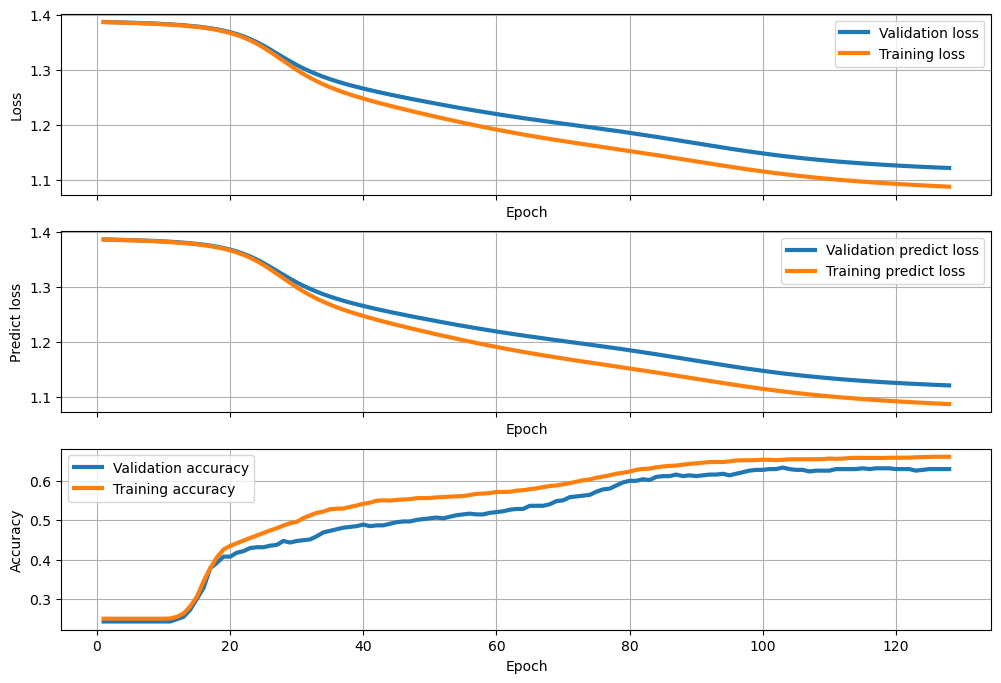

In [69]:
plot_history(hist)

In [70]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.1043 - test_predict_loss: 1.1043 - test_accuracy: 0.6402


In [71]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       133
           1       0.57      0.58      0.58       118
           2       0.67      0.47      0.55       121
           3       0.57      0.63      0.60       131

    accuracy                           0.64       503
   macro avg       0.64      0.63      0.63       503
weighted avg       0.64      0.64      0.63       503



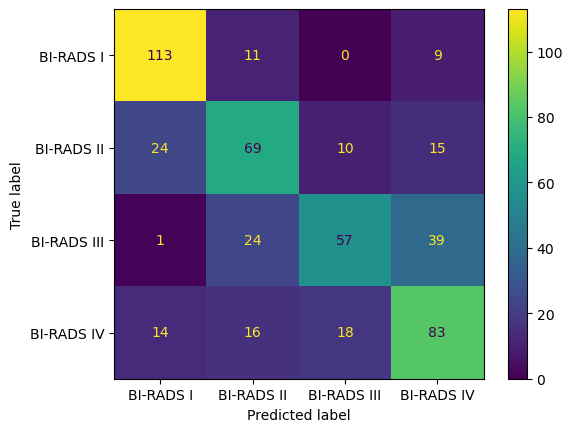

In [72]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

## MinMax

In [133]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            # MinMaxScaler(),
            HistogramEqualizer(),
            Sobel(),
            # HistogramEqualizer()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=12)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=12)}
# train_datasets = train_val_split(datasets['train'], 1 / 4, random_state=12)
# datasets['train'] = train_datasets['train']

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']),  len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

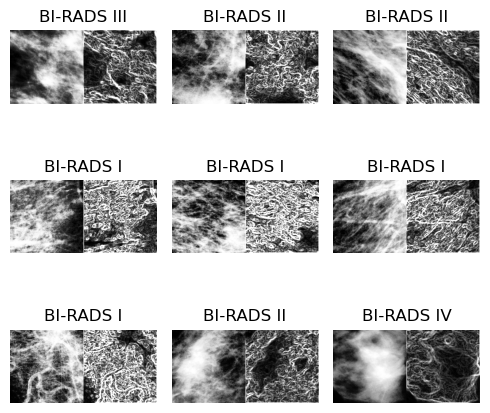

In [134]:
sample_images(dataloaders['train'], label_mapper=IrmaDataset.get_class_label, plot_borders=True)

### PVAE - 128

In [75]:
pvae = PVAE(
    latent_dim=128,
    n_channels=2,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 84)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(84, 6, 6),
    linear_layers=[128, 64],
    pred_layers=[256, 128, 64],
    use_batchnorm=True,
    n_classes=4,
    clamp_output=False
)
summary(pvae, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 84, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 128, 60, 60]         221,312
│    │    └─BatchNorm2d: 3-6             [32, 128, 60, 60]         256
│    │    └─GELU: 3-7                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 96, 28, 28]          110,688
│    │    └─BatchNorm2d: 3-10            [32, 96, 28, 28]          192

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pvae.parameters())
pvae.to(device)

hist = train(pvae, optimizer, dataloaders['train'], dataloaders['val'], 24, pred_kl_reconstruction_loss)

[epoch: 1] train_loss: 14.1052 - train_rec_loss: 12.7934 - train_kl_loss: 0.0415 - train_pred_loss: 1.2703 - train_accuracy: 0.4455 - val_loss: 3.4690 - val_rec_loss: 2.1641 - val_kl_loss: 0.0363 - val_pred_loss: 1.2687 - val_accuracy: 0.4135
[epoch: 2] train_loss: 3.0793 - train_rec_loss: 1.8413 - train_kl_loss: 0.0387 - train_pred_loss: 1.1992 - train_accuracy: 0.5234 - val_loss: 2.9489 - val_rec_loss: 1.6790 - val_kl_loss: 0.0400 - val_pred_loss: 1.2299 - val_accuracy: 0.4831
[epoch: 3] train_loss: 2.5977 - train_rec_loss: 1.3937 - train_kl_loss: 0.0457 - train_pred_loss: 1.1584 - train_accuracy: 0.5697 - val_loss: 2.6175 - val_rec_loss: 1.3908 - val_kl_loss: 0.0494 - val_pred_loss: 1.1773 - val_accuracy: 0.5388
[epoch: 4] train_loss: 2.4880 - train_rec_loss: 1.2891 - train_kl_loss: 0.0455 - train_pred_loss: 1.1534 - train_accuracy: 0.5762 - val_loss: 2.4763 - val_rec_loss: 1.2397 - val_kl_loss: 0.0434 - val_pred_loss: 1.1931 - val_accuracy: 0.5308
[epoch: 5] train_loss: 2.3109 - tr

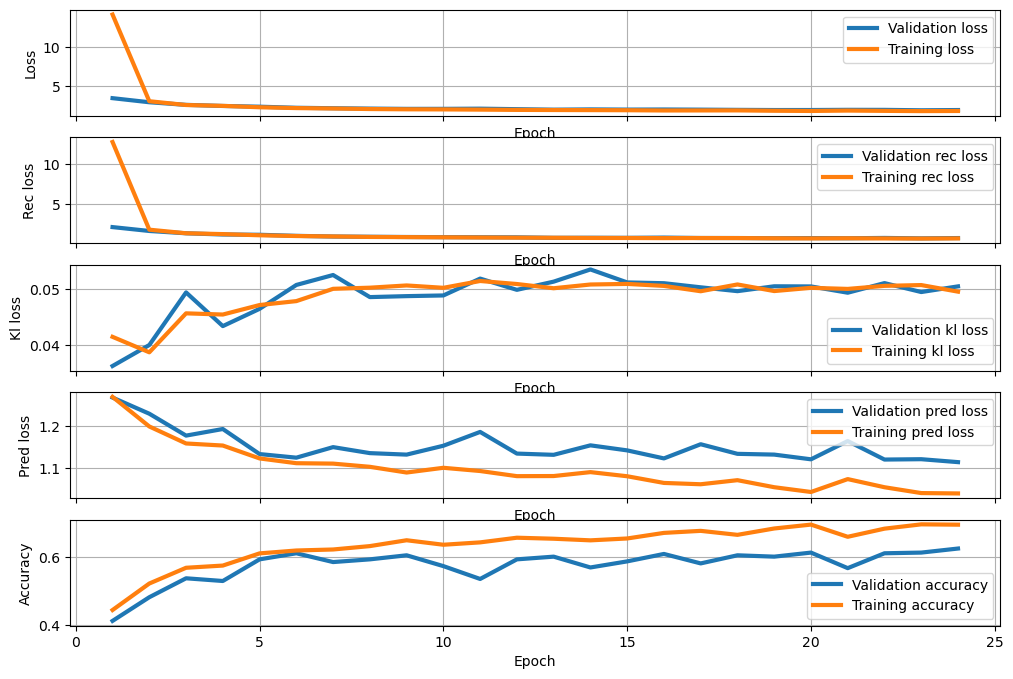

In [77]:
plot_history(hist)

test_loss: 1.8756 - test_rec_loss: 0.7518 - test_kl_loss: 0.0504 - test_pred_loss: 1.0735 - test_accuracy: 0.6600


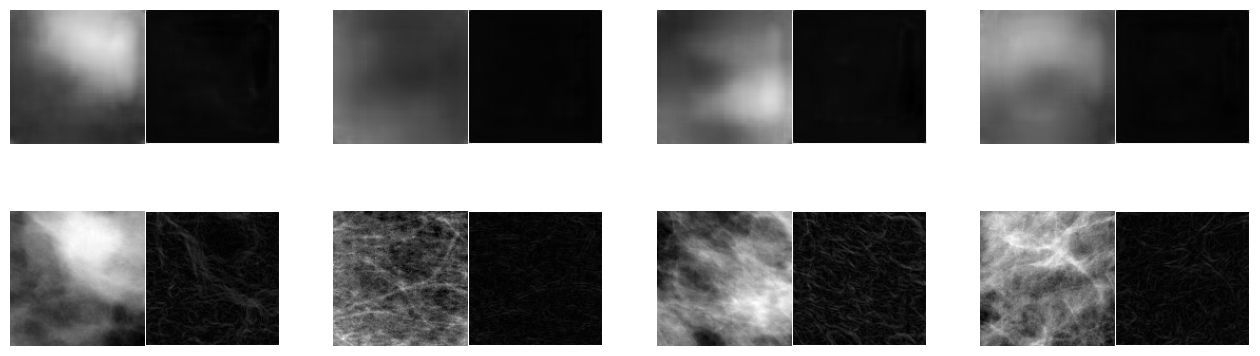

In [78]:
test_metrics = validate(pvae, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(pvae, dataloaders['test'], plot_borders=True)

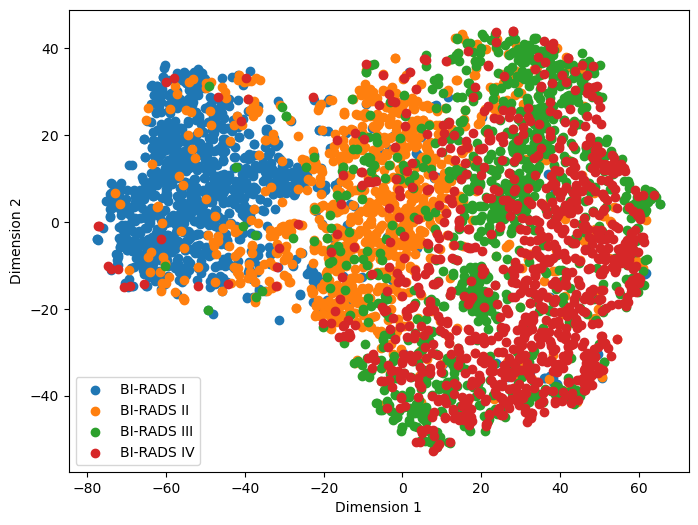

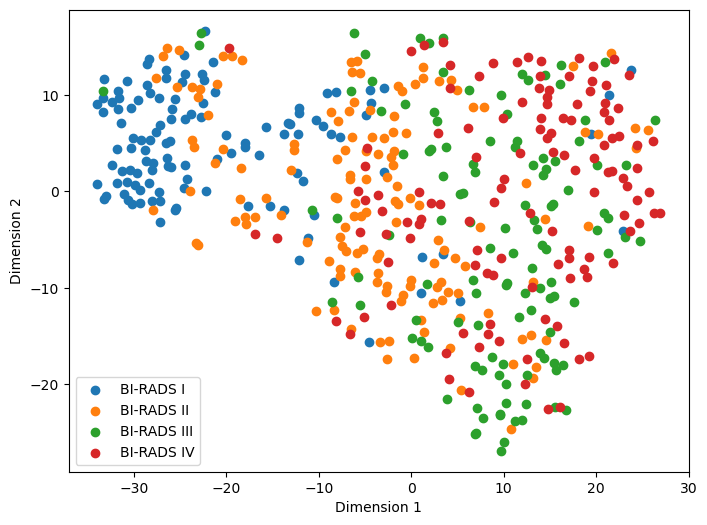

In [79]:
train_latent, train_labels = get_latent(pvae, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae, dataloaders["val"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [80]:
train_latent, train_labels = get_latent(pvae, dataloaders["train"])
val_latent, val_labels = get_latent(pvae, dataloaders["val"])
latent, labels = get_latent(pvae, dataloaders["test"])

In [81]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [82]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [89]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(128, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 16,512
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 90,948
Trainable params: 90,948
Non-trainable params: 0
Total mult-adds (M): 2.91
Input size (MB): 0.02
Forward/backward pass

In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00001)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 96, pred_loss)

[epoch: 1] train_loss: 1.3851 - train_predict_loss: 1.3851 - train_accuracy: 0.2499 - val_loss: 1.3839 - val_predict_loss: 1.3839 - val_accuracy: 0.2445
[epoch: 2] train_loss: 1.3822 - train_predict_loss: 1.3822 - train_accuracy: 0.2765 - val_loss: 1.3804 - val_predict_loss: 1.3804 - val_accuracy: 0.3598
[epoch: 3] train_loss: 1.3760 - train_predict_loss: 1.3760 - train_accuracy: 0.4552 - val_loss: 1.3717 - val_predict_loss: 1.3717 - val_accuracy: 0.4732
[epoch: 4] train_loss: 1.3574 - train_predict_loss: 1.3574 - train_accuracy: 0.5460 - val_loss: 1.3428 - val_predict_loss: 1.3428 - val_accuracy: 0.4950
[epoch: 5] train_loss: 1.3000 - train_predict_loss: 1.3000 - train_accuracy: 0.5396 - val_loss: 1.2802 - val_predict_loss: 1.2802 - val_accuracy: 0.4871
[epoch: 6] train_loss: 1.2351 - train_predict_loss: 1.2351 - train_accuracy: 0.5209 - val_loss: 1.2442 - val_predict_loss: 1.2442 - val_accuracy: 0.4831
[epoch: 7] train_loss: 1.2007 - train_predict_loss: 1.2007 - train_accuracy: 0.514

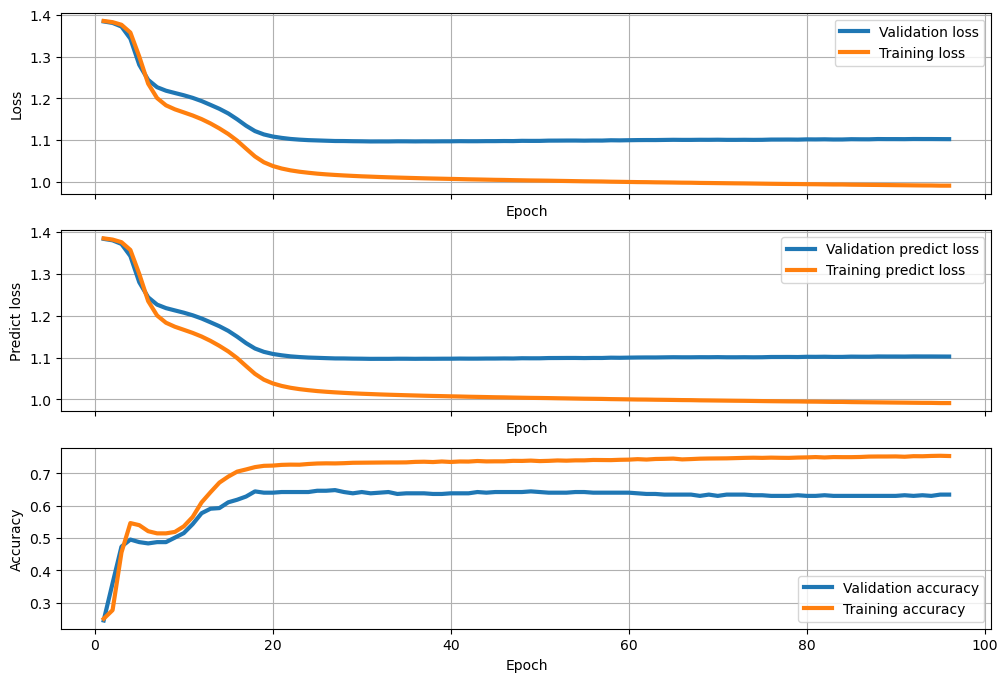

In [91]:
plot_history(hist)

In [92]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.0485 - test_predict_loss: 1.0485 - test_accuracy: 0.6899


In [93]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       133
           1       0.62      0.68      0.65       118
           2       0.62      0.52      0.57       121
           3       0.64      0.69      0.66       131

    accuracy                           0.69       503
   macro avg       0.69      0.69      0.68       503
weighted avg       0.69      0.69      0.69       503



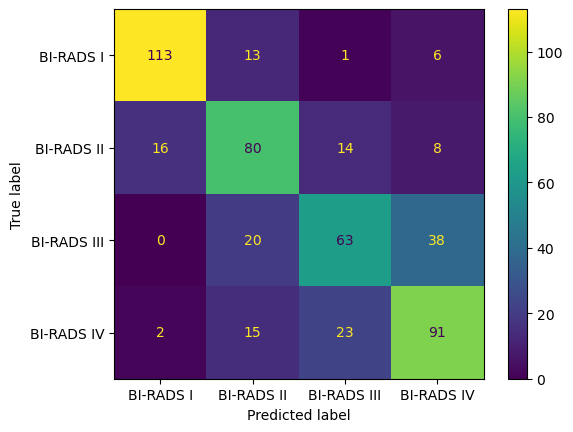

In [94]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

### PVAE - 256

In [101]:
pvae = PVAE(
    latent_dim=256,
    n_channels=2,
    conv_layers=[(5, 192), (3, 172), (3, 148), (3, 128)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(128, 6, 6),
    linear_layers=[1024, 256, 128],
    pred_layers=[256, 128, 64],
    use_batchnorm=True,
    n_classes=4,
    clamp_output=False
)
summary(pvae, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 256]                 --
│    └─Sequential: 2-1                   [32, 128, 6, 6]           --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 172, 60, 60]         297,388
│    │    └─BatchNorm2d: 3-6             [32, 172, 60, 60]         344
│    │    └─GELU: 3-7                    [32, 172, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 172, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 148, 28, 28]         229,252
│    │    └─BatchNorm2d: 3-10            [32, 148, 28, 28]         296

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pvae.parameters())
pvae.to(device)

hist = train(pvae, optimizer, dataloaders['train'], dataloaders['val'], 24, pred_kl_reconstruction_loss)

[epoch: 1] train_loss: 17.7560 - train_rec_loss: 16.3265 - train_kl_loss: 0.0416 - train_pred_loss: 1.3880 - train_accuracy: 0.2377 - val_loss: 11.0209 - val_rec_loss: 9.6106 - val_kl_loss: 0.0236 - val_pred_loss: 1.3867 - val_accuracy: 0.2604
[epoch: 2] train_loss: 10.0358 - train_rec_loss: 8.6264 - train_kl_loss: 0.0322 - train_pred_loss: 1.3772 - train_accuracy: 0.2994 - val_loss: 9.8943 - val_rec_loss: 8.4939 - val_kl_loss: 0.0323 - val_pred_loss: 1.3681 - val_accuracy: 0.3161
[epoch: 3] train_loss: 9.3795 - train_rec_loss: 8.0797 - train_kl_loss: 0.0348 - train_pred_loss: 1.2649 - train_accuracy: 0.4477 - val_loss: 9.2991 - val_rec_loss: 8.0593 - val_kl_loss: 0.0375 - val_pred_loss: 1.2023 - val_accuracy: 0.5169
[epoch: 4] train_loss: 9.0357 - train_rec_loss: 7.8194 - train_kl_loss: 0.0388 - train_pred_loss: 1.1775 - train_accuracy: 0.5545 - val_loss: 9.2247 - val_rec_loss: 8.0114 - val_kl_loss: 0.0366 - val_pred_loss: 1.1767 - val_accuracy: 0.5586
[epoch: 5] train_loss: 8.8483 - 

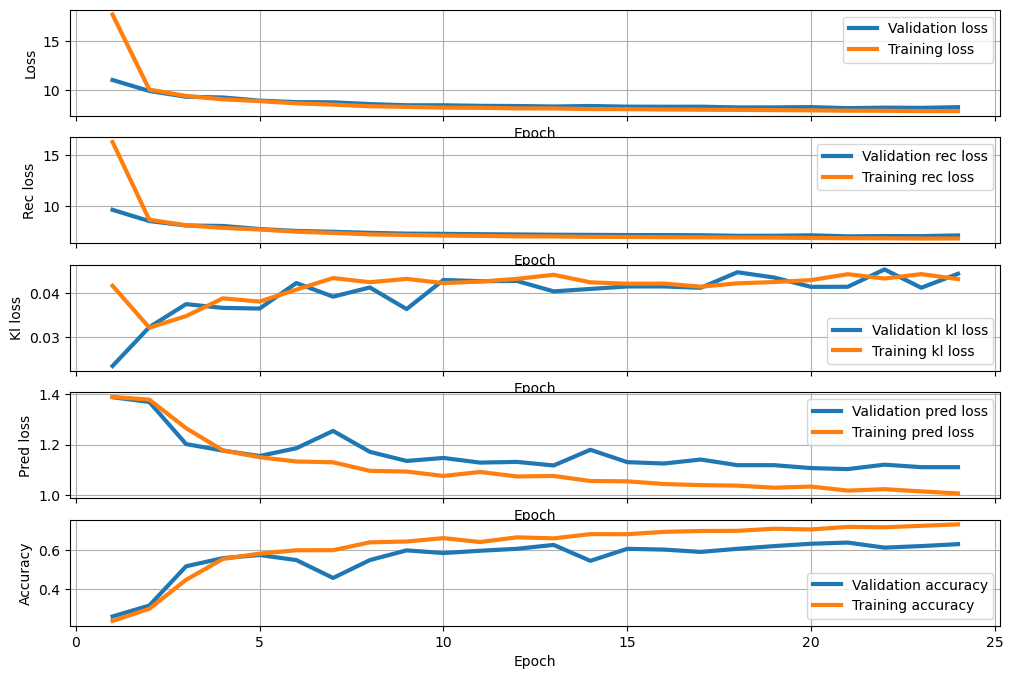

In [103]:
plot_history(hist)

test_loss: 8.2602 - test_rec_loss: 7.1321 - test_kl_loss: 0.0447 - test_pred_loss: 1.0835 - test_accuracy: 0.6481


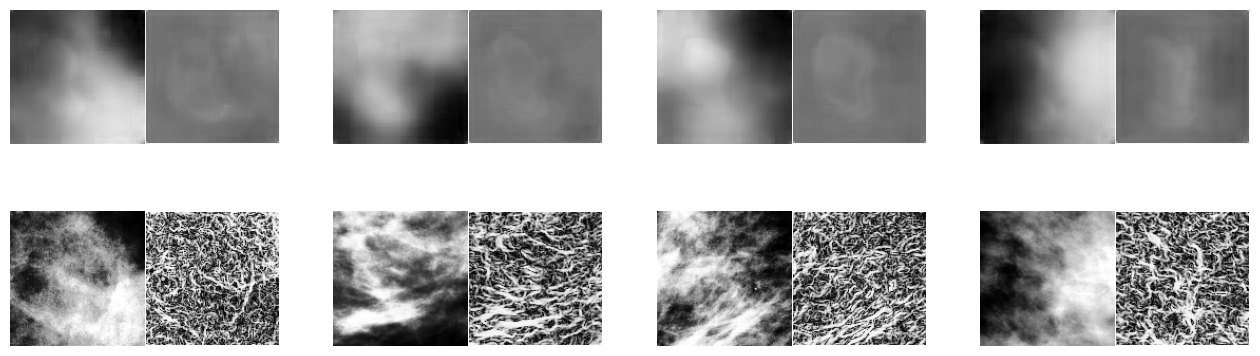

In [104]:
test_metrics = validate(pvae, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(pvae, dataloaders['test'], plot_borders=True)

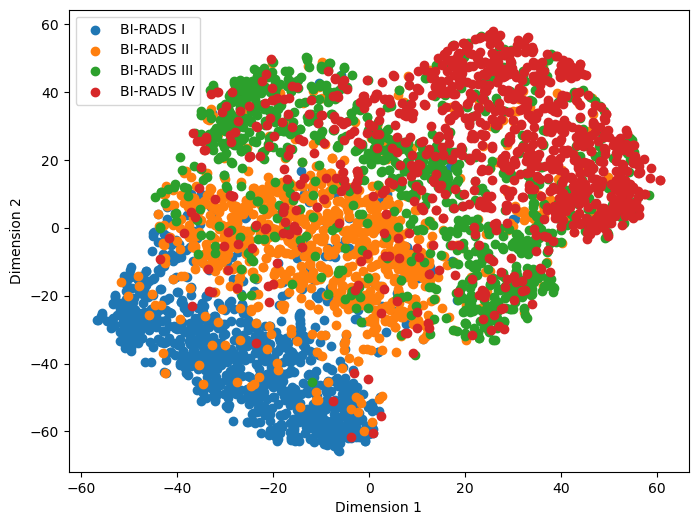

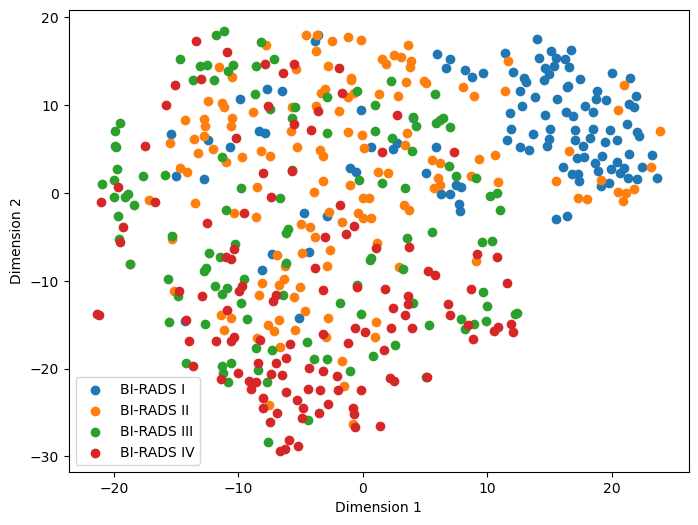

In [105]:
train_latent, train_labels = get_latent(pvae, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae, dataloaders["val"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [106]:
train_latent, train_labels = get_latent(pvae, dataloaders["train"])
val_latent, val_labels = get_latent(pvae, dataloaders["val"])
latent, labels = get_latent(pvae, dataloaders["test"])

In [107]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [108]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [111]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 256))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 32,896
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 107,332
Trainable params: 107,332
Non-trainable params: 0
Total mult-adds (M): 3.43
Input size (MB): 0.03
Forward/backward pa

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00001)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 96, pred_loss)

[epoch: 1] train_loss: 1.3855 - train_predict_loss: 1.3855 - train_accuracy: 0.2529 - val_loss: 1.3847 - val_predict_loss: 1.3847 - val_accuracy: 0.2366
[epoch: 2] train_loss: 1.3827 - train_predict_loss: 1.3827 - train_accuracy: 0.2568 - val_loss: 1.3815 - val_predict_loss: 1.3815 - val_accuracy: 0.2565
[epoch: 3] train_loss: 1.3765 - train_predict_loss: 1.3765 - train_accuracy: 0.3288 - val_loss: 1.3734 - val_predict_loss: 1.3734 - val_accuracy: 0.3479
[epoch: 4] train_loss: 1.3590 - train_predict_loss: 1.3590 - train_accuracy: 0.5543 - val_loss: 1.3483 - val_predict_loss: 1.3483 - val_accuracy: 0.5507
[epoch: 5] train_loss: 1.3049 - train_predict_loss: 1.3049 - train_accuracy: 0.6526 - val_loss: 1.2799 - val_predict_loss: 1.2799 - val_accuracy: 0.5288
[epoch: 6] train_loss: 1.2093 - train_predict_loss: 1.2093 - train_accuracy: 0.6264 - val_loss: 1.2161 - val_predict_loss: 1.2161 - val_accuracy: 0.5328
[epoch: 7] train_loss: 1.1421 - train_predict_loss: 1.1421 - train_accuracy: 0.668

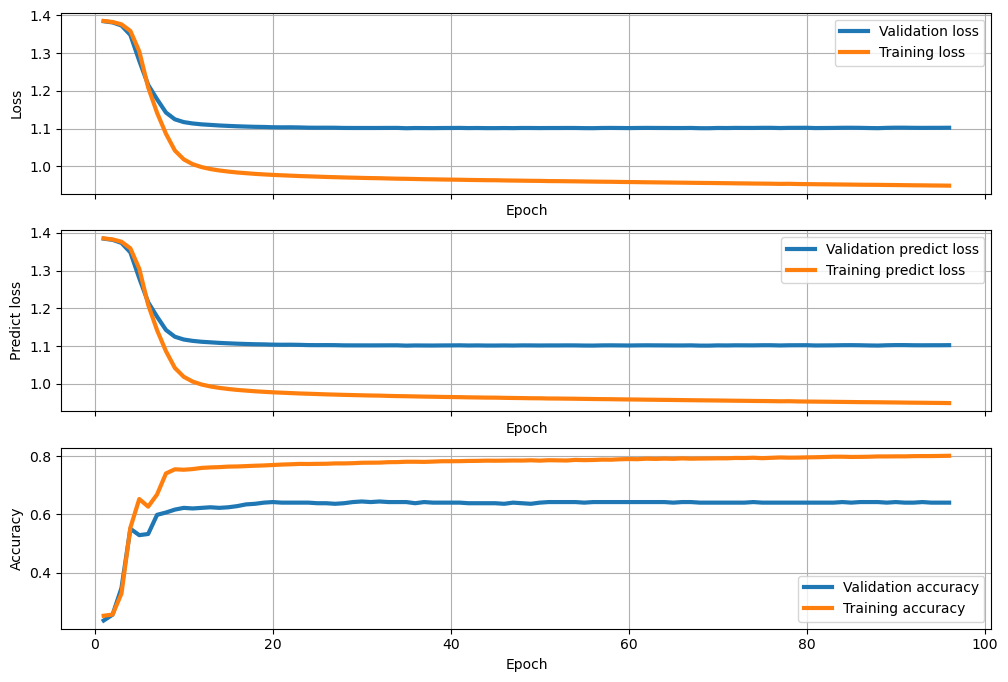

In [113]:
plot_history(hist)

In [114]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.0455 - test_predict_loss: 1.0455 - test_accuracy: 0.6958


In [115]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       133
           1       0.62      0.64      0.63       118
           2       0.61      0.55      0.58       121
           3       0.66      0.73      0.69       131

    accuracy                           0.70       503
   macro avg       0.69      0.69      0.69       503
weighted avg       0.70      0.70      0.70       503



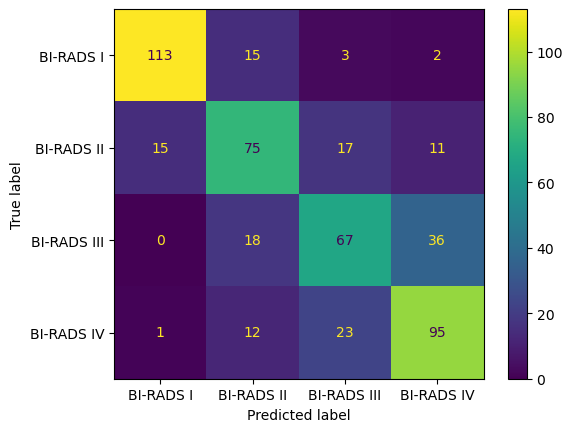

In [116]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

### PVAE - 512

In [119]:
pvae = PVAE(
    latent_dim=512,
    n_channels=2,
    conv_layers=[(5, 192), (3, 176), (3, 152), (3, 128)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(128, 6, 6),
    linear_layers=[2048, 1024, 512],
    pred_layers=[512, 256, 128],
    use_batchnorm=True,
    n_classes=4,
    clamp_output=False
)
summary(pvae, input_size=(32, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
PVAE                                     [32, 2, 128, 128]         --
├─Encoder: 1-1                           [32, 512]                 --
│    └─Sequential: 2-1                   [32, 128, 6, 6]           --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       9,792
│    │    └─BatchNorm2d: 3-2             [32, 192, 124, 124]       384
│    │    └─GELU: 3-3                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-4               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-5                  [32, 176, 60, 60]         304,304
│    │    └─BatchNorm2d: 3-6             [32, 176, 60, 60]         352
│    │    └─GELU: 3-7                    [32, 176, 60, 60]         --
│    │    └─MaxPool2d: 3-8               [32, 176, 30, 30]         --
│    │    └─Conv2d: 3-9                  [32, 152, 28, 28]         240,920
│    │    └─BatchNorm2d: 3-10            [32, 152, 28, 28]         304

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pvae.parameters())
pvae.to(device)

hist = train(pvae, optimizer, dataloaders['train'], dataloaders['val'], 24, pred_kl_reconstruction_loss)

[epoch: 1] train_loss: 20.7716 - train_rec_loss: 19.3411 - train_kl_loss: 0.0433 - train_pred_loss: 1.3872 - train_accuracy: 0.2596 - val_loss: 10.4542 - val_rec_loss: 9.0398 - val_kl_loss: 0.0295 - val_pred_loss: 1.3849 - val_accuracy: 0.2763
[epoch: 2] train_loss: 9.9039 - train_rec_loss: 8.5141 - train_kl_loss: 0.0264 - train_pred_loss: 1.3634 - train_accuracy: 0.3181 - val_loss: 9.7648 - val_rec_loss: 8.3781 - val_kl_loss: 0.0233 - val_pred_loss: 1.3635 - val_accuracy: 0.3360
[epoch: 3] train_loss: 9.3566 - train_rec_loss: 8.0732 - train_kl_loss: 0.0241 - train_pred_loss: 1.2593 - train_accuracy: 0.4582 - val_loss: 9.4442 - val_rec_loss: 8.2000 - val_kl_loss: 0.0270 - val_pred_loss: 1.2173 - val_accuracy: 0.4930
[epoch: 4] train_loss: 9.1214 - train_rec_loss: 7.8995 - train_kl_loss: 0.0271 - train_pred_loss: 1.1949 - train_accuracy: 0.5306 - val_loss: 9.1469 - val_rec_loss: 7.9550 - val_kl_loss: 0.0254 - val_pred_loss: 1.1665 - val_accuracy: 0.5447
[epoch: 5] train_loss: 9.0140 - t

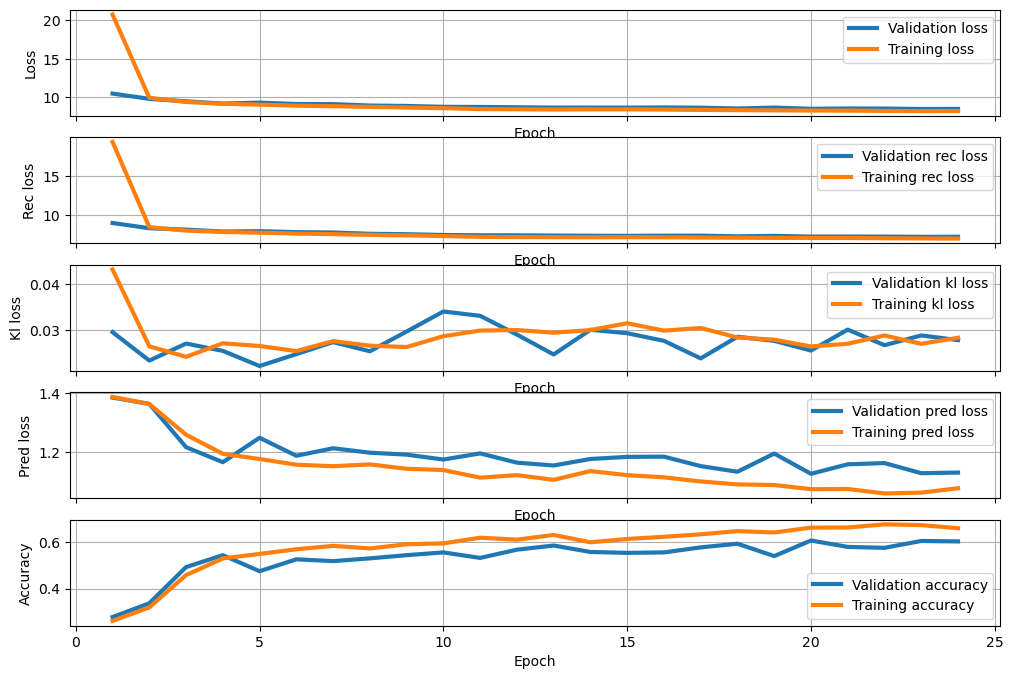

In [121]:
plot_history(hist)

test_loss: 8.5063 - test_rec_loss: 7.3733 - test_kl_loss: 0.0265 - test_pred_loss: 1.1065 - test_accuracy: 0.6243


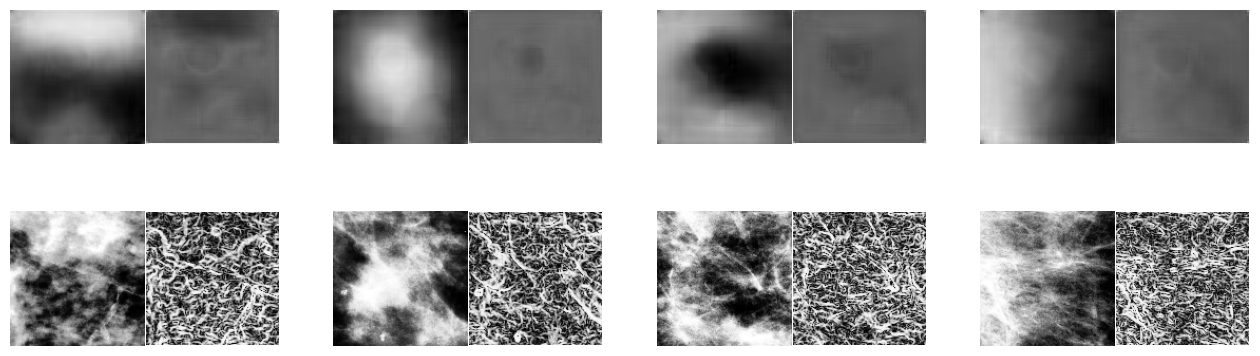

In [122]:
test_metrics = validate(pvae, dataloaders['test'], pred_kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(pvae, dataloaders['test'], plot_borders=True)

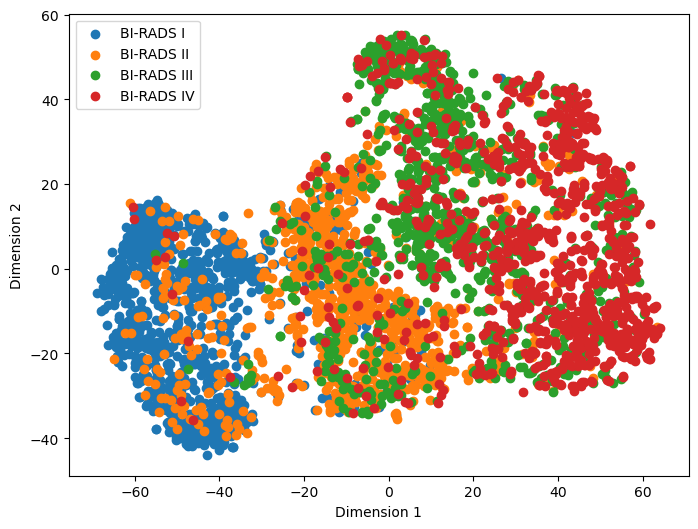

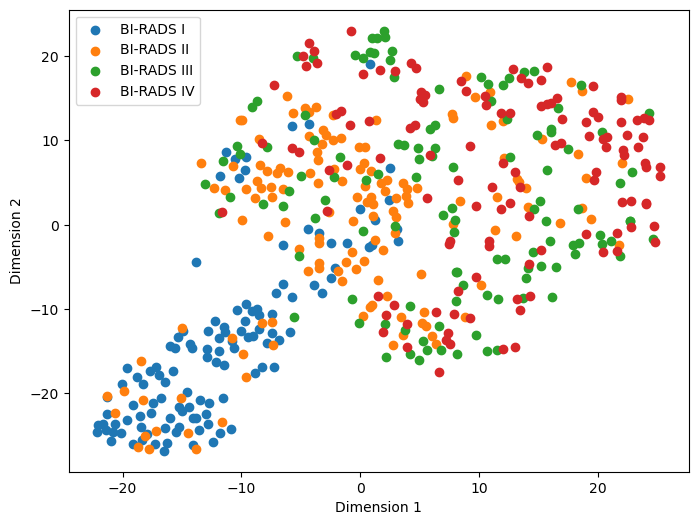

In [123]:
train_latent, train_labels = get_latent(pvae, dataloaders["train"], IrmaDataset.get_class_label)
latent, labels = get_latent(pvae, dataloaders["val"], IrmaDataset.get_class_label)

tsne = TSNE()
train_tsne_latent = tsne.fit_transform(train_latent, train_labels)
tsne_latent = tsne.fit_transform(latent)

plot_2d(train_tsne_latent, train_labels, 'tab10', IrmaDataset.get_class_label_value)
plot_2d(tsne_latent, labels, 'tab10', IrmaDataset.get_class_label_value)

In [124]:
train_latent, train_labels = get_latent(pvae, dataloaders["train"])
val_latent, val_labels = get_latent(pvae, dataloaders["val"])
latent, labels = get_latent(pvae, dataloaders["test"])

In [125]:
train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
val_latent, val_labels = val_latent.astype('float32'), val_labels.astype('int64')
latent, labels = latent.astype('float32'), labels.astype('int64')

In [126]:
train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

val_ds = TensorDataset(torch.tensor(val_latent), torch.tensor(val_labels))
val_dl = DataLoader(val_ds, batch_size)

test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
test_dl = DataLoader(test_ds, batch_size)

In [127]:
pred_model = torch.nn.Sequential(
    torch.nn.Linear(512, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 256),
    torch.nn.GELU(),
    torch.nn.Linear(256, 128),
    torch.nn.GELU(),
    torch.nn.Linear(128, 64),
    torch.nn.GELU(),
    torch.nn.Linear(64, 4),
    torch.nn.Softmax(-1)
)

summary(pred_model, (32, 512))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 4]                   --
├─Linear: 1-1                            [32, 128]                 65,664
├─GELU: 1-2                              [32, 128]                 --
├─Linear: 1-3                            [32, 256]                 33,024
├─GELU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─GELU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─GELU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 4]                   260
├─Softmax: 1-10                          [32, 4]                   --
Total params: 140,100
Trainable params: 140,100
Non-trainable params: 0
Total mult-adds (M): 4.48
Input size (MB): 0.07
Forward/backward pa

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(pred_model.parameters(), lr=0.00001)
pred_model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

hist = train(pred_model, optimizer, train_dl, val_dl, 96, pred_loss)

[epoch: 1] train_loss: 1.3850 - train_predict_loss: 1.3850 - train_accuracy: 0.2690 - val_loss: 1.3836 - val_predict_loss: 1.3836 - val_accuracy: 0.2624
[epoch: 2] train_loss: 1.3794 - train_predict_loss: 1.3794 - train_accuracy: 0.2994 - val_loss: 1.3753 - val_predict_loss: 1.3753 - val_accuracy: 0.2763
[epoch: 3] train_loss: 1.3582 - train_predict_loss: 1.3582 - train_accuracy: 0.3395 - val_loss: 1.3462 - val_predict_loss: 1.3462 - val_accuracy: 0.3936
[epoch: 4] train_loss: 1.3094 - train_predict_loss: 1.3094 - train_accuracy: 0.5192 - val_loss: 1.3012 - val_predict_loss: 1.3012 - val_accuracy: 0.5089
[epoch: 5] train_loss: 1.2417 - train_predict_loss: 1.2417 - train_accuracy: 0.5749 - val_loss: 1.2443 - val_predict_loss: 1.2443 - val_accuracy: 0.5388
[epoch: 6] train_loss: 1.1899 - train_predict_loss: 1.1899 - train_accuracy: 0.5849 - val_loss: 1.2207 - val_predict_loss: 1.2207 - val_accuracy: 0.5447
[epoch: 7] train_loss: 1.1682 - train_predict_loss: 1.1682 - train_accuracy: 0.621

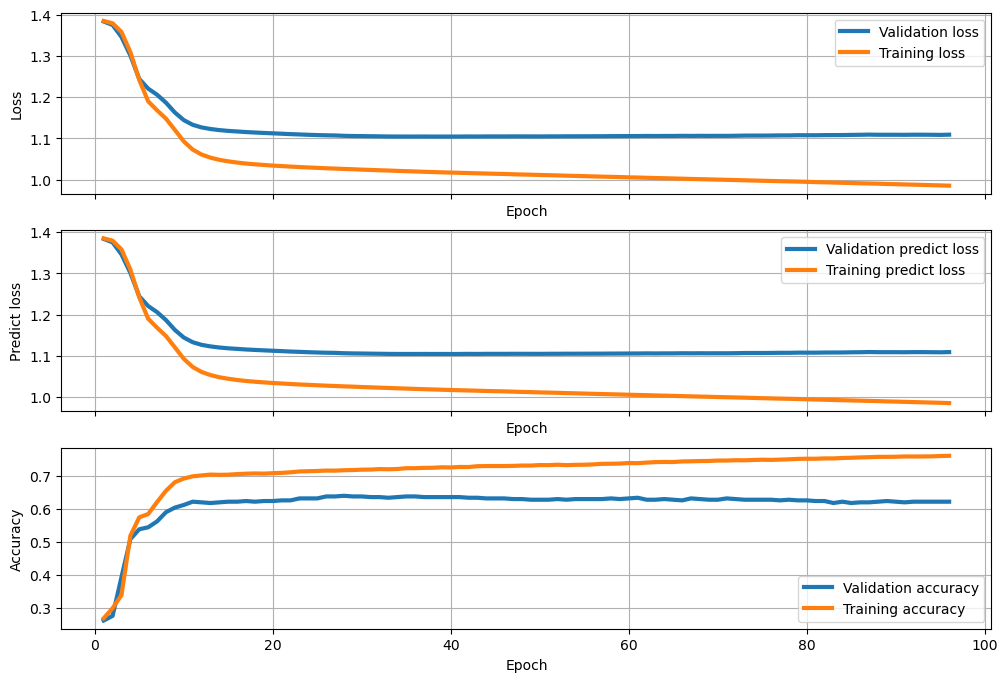

In [129]:
plot_history(hist)

In [130]:
test_metrics = validate(pred_model, test_dl, pred_loss)

print(get_metrics_str(test_metrics, 'test_'))

test_loss: 1.0728 - test_predict_loss: 1.0728 - test_accuracy: 0.6720


In [136]:
y_pred, y_true = predict(pred_model, test_dl, return_class=True)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       133
           1       0.59      0.62      0.61       118
           2       0.59      0.54      0.56       121
           3       0.65      0.69      0.67       131

    accuracy                           0.67       503
   macro avg       0.67      0.67      0.67       503
weighted avg       0.67      0.67      0.67       503



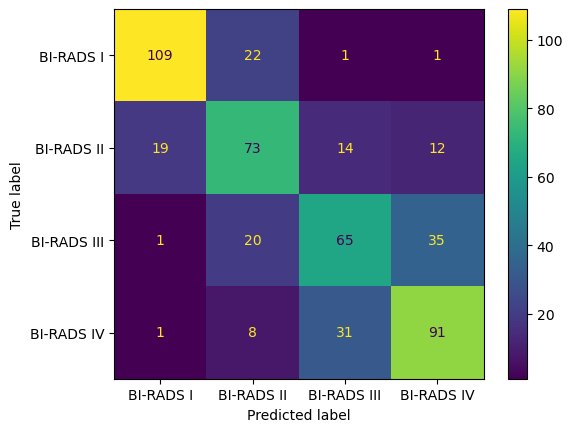

In [137]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()